In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
torch.manual_seed(42)
loss_evolution = []

def grad(outputs, inputs):
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)

def func(data):
    r, theta = x[:, 0], x[:, 1]
    return r*torch.cos(t)



def PINN(fcnn, domain, lengh, batch_size, learning_rate, epochs, itr_show):
    model = fcnn
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    r = torch.linspace(0, 1, batch_size)
    t = torch.linspace(0, 2*torch.pi, batch_size)

    R, T = torch.meshgrid((r, t), indexing="ij")
    
    data = torch.vstack([R.ravel(), T.ravel()]).T # reshape the grid into a 2D array of points
    
    data.requires_grad = True
    indices1 = (data[:, 0] == 1).nonzero(as_tuple=True)[0]
    indices2 = (data[:, 1] == 0).nonzero(as_tuple=True)[0]
    indices3 = (data[:, 1] == 2*torch.pi).nonzero(as_tuple=True)[0]
    list1 = []
    for epoch in range(epochs):
        f = model(data)
        
        dfdr = torch.autograd.grad(f, data, grad_outputs=torch.ones_like(f), create_graph=True)[0][:, 0]
        dfdr2 = torch.autograd.grad(dfdr, data, grad_outputs=torch.ones_like(dfdr), create_graph=True)[0][:, 0]
        dfdt = torch.autograd.grad(f, data, grad_outputs=torch.ones_like(f), create_graph=True)[0][:, 1]
        dfdt2 = torch.autograd.grad(dfdt, data, grad_outputs=torch.ones_like(dfdr), create_graph=True)[0][:, 1]

        loss = torch.mean(( data[:, 0]*dfdr + (data[:, 0]**2)*(dfdr2)  + (dfdt2) )**2) + torch.mean((f[indices1] - torch.cos(data[indices1,1:2]))**2) + torch.mean((f[indices2] - f[indices3])**2) 
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if (epoch) % itr_show == 0:
            print(f'iteration {epoch}/{epochs}, loss = {loss}')

    del loss, f
    
    predicted = model(data)
    predicted = torch.reshape(predicted, (batch_size, batch_size))

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)
    c = ax.contourf(T.cpu().detach().numpy(), R.cpu().detach().numpy(), predicted.cpu().detach().numpy(), 50, cmap='viridis')
    fig.colorbar(c)
    plt.show()
    return loss_evolution, list1

In [3]:
torch.manual_seed(42)

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l5 = nn.Linear(hidden_size, output_size)
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        out = self.tanh(self.l1(x))
        out = self.tanh(self.l2(out))
        out = self.tanh(self.l3(out))
        out = self.l5(out)
        return out
input_size, hidden_size, output_size = 2, 50, 1
NN = NeuralNet(input_size, hidden_size, output_size)

iteration 0/5000, loss = 0.5575297474861145
iteration 1000/5000, loss = 0.0027214381843805313
iteration 2000/5000, loss = 0.0011872730683535337
iteration 3000/5000, loss = 0.0007460011984221637
iteration 4000/5000, loss = 0.0004578779626172036


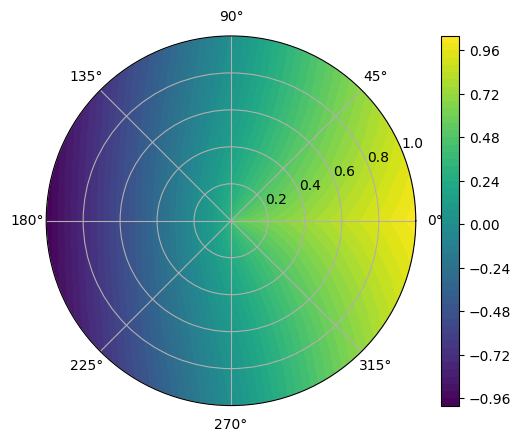

In [4]:
from matplotlib.cm import get_cmap
loss1 = []
lengh = 1.0
domain = (0, 1)
batch_size = 31
learning_rate = 0.001
epochs = 5000
loss1, list1 = PINN(NN, domain, lengh, batch_size, learning_rate, epochs, 1000)